<h1 style=><center><font color='green'>Face Detection Using Classification</font></center><h1>

<h3><center>Data Analysis and Cleaning: </center><h3>

In [13]:
#importing required libraries
import os
import shutil
from PIL import Image
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import pywt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [2]:
img  = cv2.imread('testimg/binny.jpg') #* opencv function to read image
img.shape

(1944, 2592, 3)

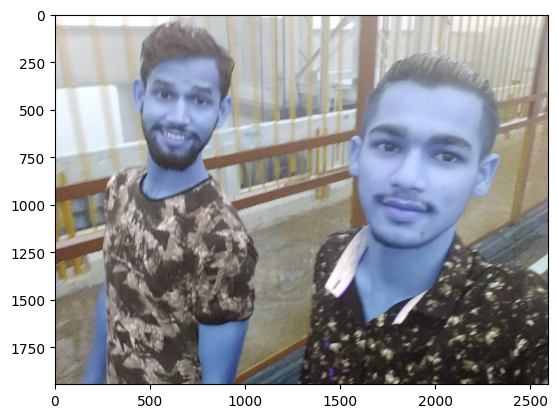

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #* for converting image to grayscale
gray.shape #* returns a 2-d image array without rgb

(1944, 2592)

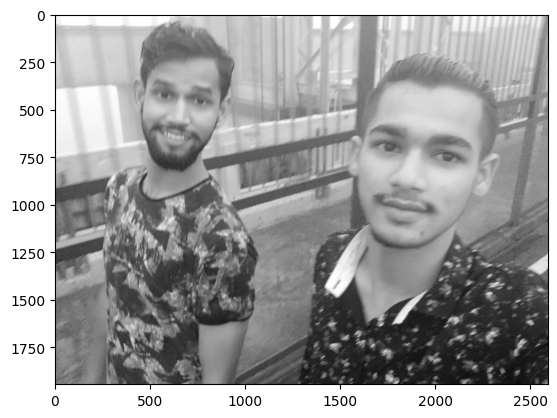

In [5]:
plt.imshow(gray, cmap="gray")

In [6]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_frontalface_alt.xml') #* importing face xml
eye_cascade = cv2.CascadeClassifier('opencv/haarcascades/haarcascade_eye_tree_eyeglasses.xml')#* importing eye xml

faces = face_cascade.detectMultiScale(gray, 1.3, 5) #* detecting faces in 'gray' image
faces

array([[ 384,  225,  539,  539],
       [1499,  395,  792,  792]], dtype=int32)

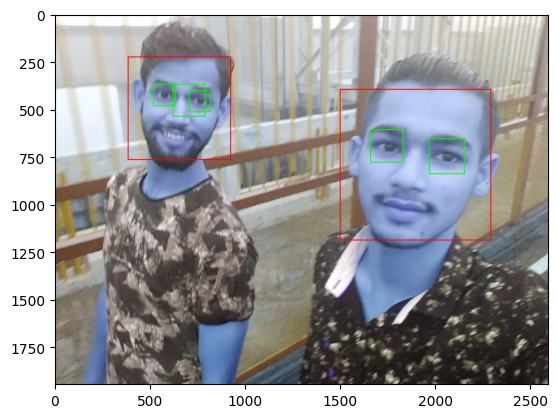

In [7]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),3) #* highlighting face with red rectangle
    roi_gray = gray[y:y+h, x:x+w] #* extracting face(region of interest) only from gray image for eye detection
    roi_color = face_img[y:y+h, x:x+w] #* extracting face(region of interest) from colored image
    eyes = eye_cascade.detectMultiScale(roi_gray) #* detecting eyes in roi_gray
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),3) #* highlighting eyes in cropped colored image
plt.imshow(face_img, cmap='gray')


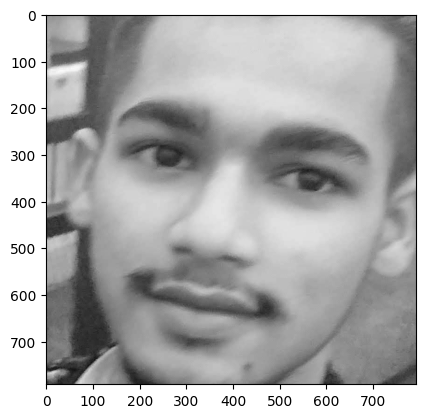

In [8]:
plt.imshow(roi_gray, cmap='gray')

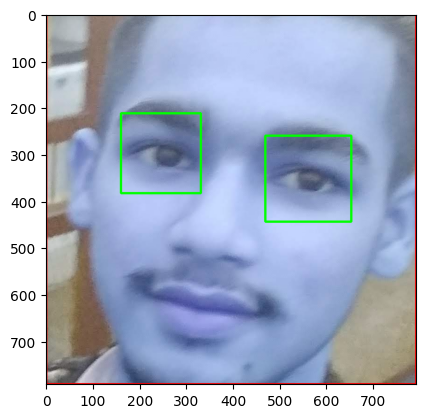

In [9]:
plt.imshow(roi_color, cmap='gray')

In [50]:
def get_cropped_img_if_2_eyes(img_path): #* function for cropping out faces from main image
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    roi_color=[] #* array for storing multiple faces

    
    for x,y,w,h in faces:
           roi_color.append(img[y:y+h, x:x+w])
    roi_required_size = []
    for face in roi_color:
           img = Image.fromarray(face)
           img = img.resize((160,160))
           face_array = asarray(img)
           roi_required_size.append(face_array)
    return roi_required_size
        

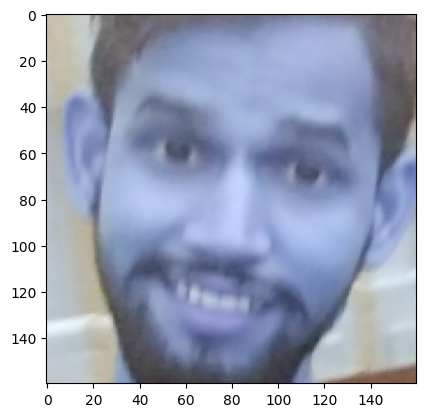

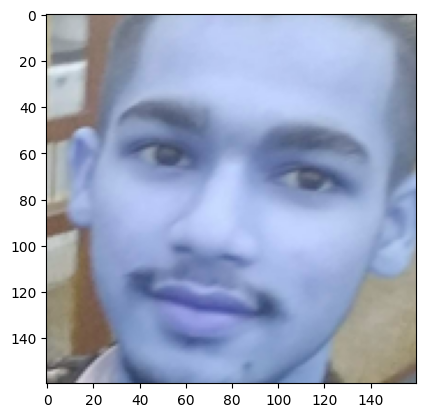

In [51]:
cropped_image = get_cropped_img_if_2_eyes('testimg/binny.jpg') #* testing above function
for face in cropped_image:
    plt.imshow(face)
    plt.show()


In [46]:
path_to_data = './dataset/'
path_to_cr_data = './dataset/cropped/'

In [47]:
img_dirs = [] #* list for storing directory paths to get names of persons/friends
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
img_dirs

['./dataset/aayushi',
 './dataset/abhishek',
 './dataset/binod',
 './dataset/sid',
 './dataset/vandana',
 './dataset/cropped']

In [48]:
if os.path.exists(path_to_cr_data): #! deleting previous cropped folder and creating a new one. Only run if training model again
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [52]:
friend_file_names_dict = {}
for img_dir in img_dirs: #* iterating over each directory inside dataset
    count = 1
    friend_name = img_dir.split('/')[-1] #* extracting person's name from path
    print(friend_name)
    
    for entry in os.scandir(img_dir): #* iterating over each image file inside img_dir
        roi_color = get_cropped_img_if_2_eyes(entry.path) #* cropping out faces and saving them in roi_color
        if len(roi_color) > 0:
            cropped_folder = path_to_cr_data + friend_name #* assigning path for cropped images folder
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            
            for cropped_image in roi_color: #* iterating over each face inside roi_color
                cropped_file_name = friend_name + str(count) + ".png" #* assigning file name of images eg binny1.png, binny2.png
                cropped_file_path = cropped_folder + "/" + cropped_file_name  #* assigning path to each image
                cv2.imwrite(cropped_file_path, cropped_image) #* saving the image in cropped_image to cropped folder
                count += 1
                
            
            
                

aayushi
abhishek
Generating cropped images in folder:  ./dataset/cropped/abhishek
binod


In [22]:
friend_file_names_dict = {} #* creating a dict to store names of friends as keys and file paths as values
for entry in os.scandir(path_to_cr_data):
    friend_name = entry.path.split('/')[-1] #* extracting friend name from path
    friend_file_names_dict[friend_name] = [] #* initializing friend name key inside dict
    for i in os.scandir(entry.path):
        friend_file_names_dict[friend_name].append(i.path) #* storing image path as value inside dict

In [23]:
friend_file_names_dict

{'aayushi': ['./dataset/cropped/aayushi/aayushi1.png',
  './dataset/cropped/aayushi/aayushi12.png',
  './dataset/cropped/aayushi/aayushi13.png',
  './dataset/cropped/aayushi/aayushi14.png',
  './dataset/cropped/aayushi/aayushi15.png',
  './dataset/cropped/aayushi/aayushi16.png',
  './dataset/cropped/aayushi/aayushi17.png',
  './dataset/cropped/aayushi/aayushi18.png',
  './dataset/cropped/aayushi/aayushi19.png',
  './dataset/cropped/aayushi/aayushi2.png',
  './dataset/cropped/aayushi/aayushi20.png',
  './dataset/cropped/aayushi/aayushi21.png',
  './dataset/cropped/aayushi/aayushi22.png',
  './dataset/cropped/aayushi/aayushi23.png',
  './dataset/cropped/aayushi/aayushi24.png',
  './dataset/cropped/aayushi/aayushi25.png',
  './dataset/cropped/aayushi/aayushi27.png',
  './dataset/cropped/aayushi/aayushi28.png',
  './dataset/cropped/aayushi/aayushi29.png',
  './dataset/cropped/aayushi/aayushi3.png',
  './dataset/cropped/aayushi/aayushi30.png',
  './dataset/cropped/aayushi/aayushi31.png',
  

<h3><center>Wavelet Transform of image :</center><h3>


In [16]:
def w2d(img, mode='haar', level=1): 
    #* Courtesy of - 
    #* https://stackoverflow.com/questions/24536552/how-to-combine-pywavelet-and-opencv-for-image-processing

    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

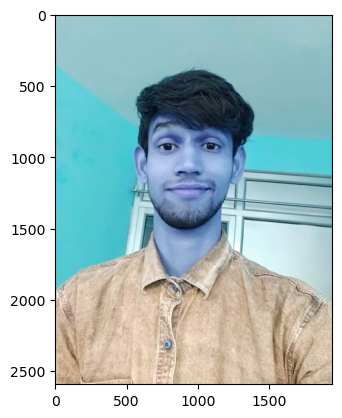

In [39]:
original_image = cv2.imread('testimg/binny2.jpg')
plt.imshow(original_image)


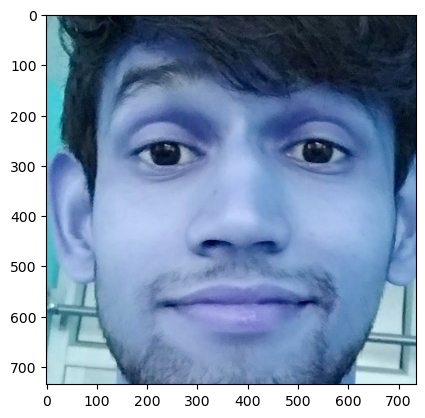

In [40]:
faces = get_cropped_img_if_2_eyes('testimg/binny2.jpg')
for face in faces:
    plt.imshow(face)
    plt.show()

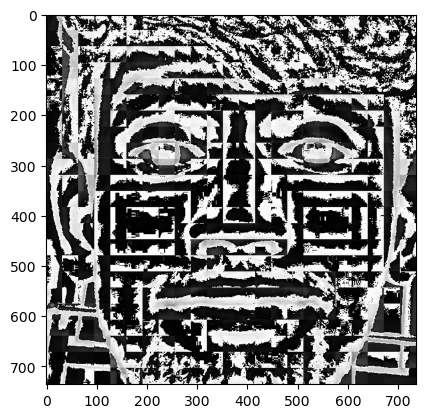

In [41]:
wavelet_transform_image = w2d(face, 'db1', 5) #* testing wavelet transform function
plt.imshow(wavelet_transform_image, cmap='gray')

In [24]:
class_dict = {} #* dict for converting and storing friends' names as classes
count = 0
for friend_name in friend_file_names_dict.keys():
    class_dict[friend_name] = count
    count = count + 1
class_dict

{'aayushi': 0, 'abhishek': 1, 'binod': 2, 'sid': 3, 'vandana': 4}

<h3><center>Feature Scaling and Data Preparation :</center><h3>

In [25]:
X, y = [], []
for friend_name, training_files in friend_file_names_dict.items(): 
    for training_image in training_files: #* iterating over each image path inside friends dict
        img = cv2.imread(training_image)
        scaled_raw_img = cv2.resize(img, (32, 32)) #* scaling colored image
        img_har = w2d(img,'db1',5) #* wavelet transform of image
        scaled_img_har = cv2.resize(img_har, (32, 32)) #* scaling wavelet transformed image
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1))) #* stacking both images vertically
        X.append(combined_img) #* storing combined image in X
        y.append(class_dict[friend_name]) #* storing labels/classes of friend names in y

In [44]:
len(X[0])

4096

In [26]:
X = np.array(X).reshape(len(X), 4096).astype(float) #* converting X to numpy array for training

In [46]:
X.shape

(247, 4096)

In [47]:
y = np.array(y) #! no need to use this conversion if you are using train_test_split
y = y.ravel() #* making y one-dimensional since Stratified Shuffle was throwing error
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4])

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 10))])
#pipe.fit(X_train, y_train)
#score = pipe.score(X_test, y_test) * 100
#print('Score:',score,'%')

In [48]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0) #* using Stratified Shuffling as no. of images for each friend is different, model fits better with this
for train_index, test_index in sss.split(X, y):
    
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


<h3><center>Training & Prediction :</center><h3>

In [57]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 10))]) #* testing with random HP's
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test) * 100
print('Score:',score,'%')

Score: 90.66666666666666 %


In [58]:
print(classification_report(y_test, pipe.predict(X_test))) #* analyzing precision

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.93      0.93      0.93        15
           2       1.00      0.91      0.95        11
           3       0.88      0.82      0.85        17
           4       1.00      1.00      1.00        22

    accuracy                           0.91        75
   macro avg       0.89      0.89      0.89        75
weighted avg       0.91      0.91      0.91        75



In [60]:
model_params = { #* dict containing different models and HP's for passing to GridSearchCV
    
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear','sigmoid']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    },
    
    'knn': {
        'model': KNeighborsClassifier(),
        'params' : { 'kneighborsclassifier__n_neighbors' : [5,7,9,11,13,15]
        }
    },
    
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'decisiontreeclassifier__min_impurity_decrease' : [0.2,0.3,0.4,0.5],
            'decisiontreeclassifier__max_depth' : [3,4,5,6],
            'decisiontreeclassifier__min_samples_leaf' : [3,4,5,6]
        }
    }
}


In [61]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False) #* using GridSearchCV for finding best fiting model
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df #* printing scores and models with best HP's

,model,best_score,best_params
0,svm,0.819496,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.587059,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.836639,{'logisticregression__C': 1}
3,knn,0.633445,{'kneighborsclassifier__n_neighbors': 5}
4,decision_tree,0.290756,"{'decisiontreeclassifier__max_depth': 3, 'deci..."


In [64]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 'decision_tree': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('decisiontreeclassifier',
                  DecisionTreeClassifier(max_depth=3, min_impurity_decrease=0.2,
                                         min_samples_leaf=3))])}

In [65]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.88

In [66]:
best_estimators['svm'].score(X_test, y_test)

0.9066666666666666

In [67]:
best_clf = best_estimators['svm'] #* chose SVM despite GridSearch showing Logistic Regression better since SVM gives better score on test data.

In [68]:
cm = confusion_matrix(y_test, best_clf.predict(X_test)) 
cm

array([[ 8,  1,  0,  1,  0],
       [ 1, 14,  0,  0,  0],
       [ 0,  0, 10,  1,  0],
       [ 3,  0,  0, 14,  0],
       [ 0,  0,  0,  0, 22]])

{'aayushi': 0, 'abhishek': 1, 'binod': 2, 'vandana': 3, 'sid': 4}


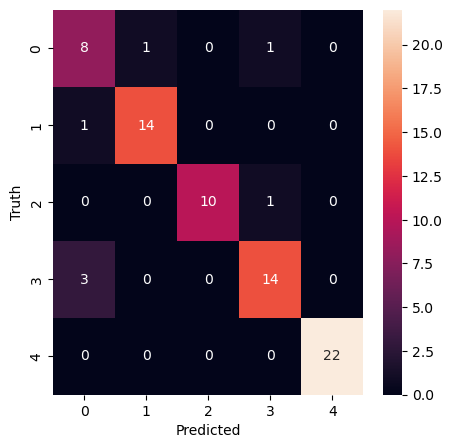

In [69]:
plt.figure(figsize = (5,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(class_dict)

In [71]:
import joblib
joblib.dump(best_clf, 'saved_model.pkl') #* saving the selected model(svm.SVC)

['saved_model.pkl']

In [72]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict)) #*saving the class_dict as json for use in backend